<a href="https://colab.research.google.com/github/pshkrsam/chsri/blob/main/Emergency_Response_for_Injuries_Caused_By_Motor_Vehicle_Collisions_in_Toronto%2C_CA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing an emergency response mechanism in the Greater Toronto area by identifying hospitals in close proximity to motor vehicle collision spots.

Connecting to Google Drive...

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


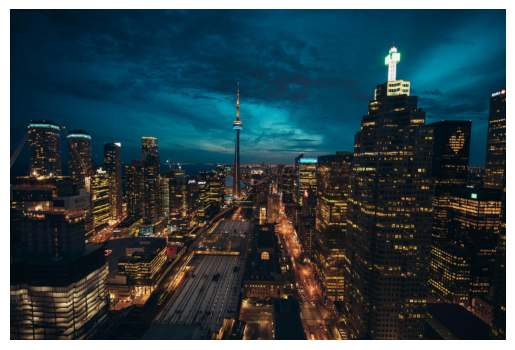

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread('/content/drive/MyDrive/CHSRI/pexels-rpnickson-2478248.jpg')

# Display the image
plt.imshow(img)
plt.axis('off')  # To hide axes
plt.show()

## For the purposes of this analysis, we will utilize two major data sources: motor vehicle collisions data from Toronto Police's [Public Safety Data Portal](https://data.torontopolice.on.ca/datasets/bc4c72a793014a55a674984ef175a6f3/explore) and hospital location data from [Ontario Ministry of Health.](https://geohub.lio.gov.on.ca/datasets/lio::ministry-of-health-service-provider-locations/about) The data considers collisions to be contact resulting from the motion of a motor vehicle or streetcar or its load, which produces property damage, injury or death. The term collision indicates that the initial point of contact involved at least one motor vehicle or streetcar.

### Before we get started, we need to set up the packages that will be essential for the analysis.

In [3]:
!pip install geopandas
!pip install pandas
!pip install shapely
!pip install -U folium

In [4]:
!pip install git+https://github.com/ML-Challenge/learntools.git

  Cloning https://github.com/ML-Challenge/learntools.git to /tmp/pip-req-build-q6718r_h
  Running command git clone --filter=blob:none --quiet https://github.com/ML-Challenge/learntools.git /tmp/pip-req-build-q6718r_h
  Resolved https://github.com/ML-Challenge/learntools.git to commit 7789b364becf7676ae8e82bb7dd9631c841fc2c8
  Preparing metadata (setup.py) ... done
  Created wheel for learntools: filename=learntools-0.3.4-py3-none-any.whl size=207291 sha256=f1ae89dc50eb1af63ccd72fba1717e9456b1d36c39b7dfea6756d8c6bdfe5d72
  Stored in directory: /tmp/pip-ephem-wheel-cache-ltoz9_ik/wheels/f9/a1/22/8f41707716f7d976497a5c8d86ebbf3691ed78d4647c1afdb4
Successfully built learntools


In [5]:
import math
import geopandas as gpd
import pandas as pd
from shapely.geometry import MultiPolygon

import folium
from folium import Choropleth, Marker
from folium.plugins import HeatMap, MarkerCluster

from google.colab import files
from IPython.display import HTML

from learntools.core import binder; binder.bind(globals())
from learntools.python.ex5 import *
print('Setup complete.')

Setup complete.


### Setting up a function for embedding maps for visualizations

In [6]:
def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    display(IFrame(file_name, width='700px', height='500px'))

In [7]:
injuries = gpd.read_file('/content/drive/MyDrive/CHSRI/Collisions_Injuries.shp')

In [8]:
injuries.head()

,OBJECTID,EVENT_UNIQ,OCC_DATE,OCC_MONTH,OCC_DOW,OCC_YEAR,OCC_HOUR,DIVISION,FATALITIES,INJURY_COL,...,HOOD_158,NEIGHBOURH,LONG_WGS84,LAT_WGS84,AUTOMOBILE,MOTORCYCLE,PASSENGER,BICYCLE,PEDESTRIAN,geometry
0,1,GO-20141260983,2014-01-01,January,Wednesday,2014,4,D43,0,YES,...,157,Bendale South (157),-79.255355,43.753522,YES,NO,YES,NO,NO,POINT (-8822665.789 5427378.033)
1,3,GO-20141260499,2014-01-01,January,Wednesday,2014,2,NSA,0,YES,...,NSA,NSA,0.000000,0.000000,YES,NO,NO,NO,NO,POINT (0.000 0.000)
2,5,GO-20141261162,2014-01-01,January,Wednesday,2014,5,NSA,0,YES,...,NSA,NSA,0.000000,0.000000,YES,NO,NO,NO,NO,POINT (0.000 0.000)
3,10,GO-20141261706,2014-01-01,January,Wednesday,2014,9,NSA,0,YES,...,NSA,NSA,0.000000,0.000000,YES,NO,YES,NO,NO,POINT (0.000 0.000)
4,11,GO-20141263444,2014-01-01,January,Wednesday,2014,17,D55,0,YES,...,NSA,NSA,0.000000,0.000000,YES,NO,NO,NO,NO,POINT (0.000 0.000)


In [9]:
zero_lat_lon_count = injuries[(injuries['LAT_WGS84'] == 0) | (injuries['LONG_WGS84'] == 0)].shape[0]
print(f'Number of rows with 0 latitude or longitude: {zero_lat_lon_count}')

Number of rows with 0 latitude or longitude: 11280


In [10]:
print(f'Number of rows before removal: {injuries.shape[0]}')
injuries = injuries[(injuries['LAT_WGS84'] != 0) & (injuries['LONG_WGS84'] != 0)] #Removing rows with 0 in latitude and longtitude values
print(f'Number of rows after removal: {injuries.shape[0]}')

Number of rows before removal: 91753
Number of rows after removal: 80473


In [11]:
map_1 = folium.Map (location=[43.651070, -79.347015], zoom_start=11)
map_1

In [12]:
HeatMap(data=injuries[['LAT_WGS84', 'LONG_WGS84']], radius=9).add_to(map_1)

In [13]:
map_1

### We can see collisions resulting in injuries are largely evenly distributed across the Greater Toronto area, with larger incidence around the Financial District.

In [15]:
hospitals = gpd.read_file('/content/drive/MyDrive/CHSRI/Ministry_of_Health_service_provider_locations.shp')
hospitals.head()

,FID,OBJECTID,OGF_ID,MOH_SERVIC,SERVICE_TY,SERVICE__1,ENGLISH_NA,FRENCH_NAM,ENGLISH__1,FRENCH_N_1,ADDRESS_LI,ADDRESS__1,ADDRESS_DE,COMMUNITY,POSTAL_COD,GEOMETRY_U,EFFECTIVE_,geometry
0,1,1001,1001,3107,Mental Health and Addiction Organization,Mental Health Services,People Advocating for Change Through Empowerme...,None,None,None,301 Main Street,None,Practice Location,Geraldton,P0T1M0,None,2023-03-28,POINT (-9679057.480 6398664.399)
1,2,1002,1002,3108,Mental Health and Addiction Organization,Mental Health Services,People Advocating for Change Through Empowerme...,None,None,None,1 Healthcare Crescent,Manitouwadge Health Care Centre,Practice Location,Manitouwadge,P0T2C0,None,2023-03-28,POINT (-9553960.944 6296550.179)
2,3,1003,1003,3109,Mental Health and Addiction Organization,Mental Health Services,People Advocating for Change Through Empowerme...,None,None,None,313 Scotia Street,None,Practice Location,Schreiber,P0T2S0,None,2023-03-28,POINT (-9714559.971 6242357.094)
3,4,1004,1004,30708,Mental Health and Addiction Organization,Mental Health Services,People Advocating for Change Through Empowerme...,None,None,None,510 Victoria Avenue East,None,Practice Location,Nipigon,P7C1A7,None,2023-03-28,POINT (-9825423.441 6276985.279)
4,5,1005,1005,3106,Mental Health and Addiction Organization,Mental Health Services,Eden Community Homes,None,None,None,196 Beverley Street,None,Administrative Office,Toronto,M5T1Z1,None,2023-03-28,POINT (-8838229.584 5412415.612)
